In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import filters
from skimage.transform import resize
from skimage.filters import gaussian
from skimage import morphology
from sklearn.neighbors import KNeighborsClassifier

In [1]:
file_im = 'example_image/ISIC_0001769.jpg'
im = plt.imread(file_im)
plt.imshow(im)

NameError: name 'plt' is not defined

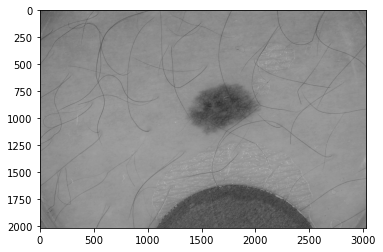

In [26]:
im2 = im[0:1500,:,:]
im2 = rgb2gray(im)*256
plt.imshow(im2, cmap='gray')

In [27]:
val = filters.threshold_otsu(im2)
print(val)

130.99889686274508


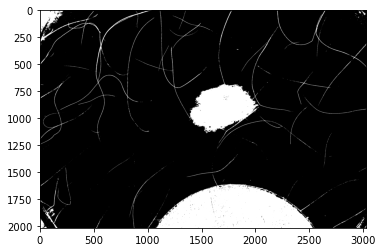

In [28]:
mask = im2 < val
plt.imshow(mask, cmap='gray')

## Morphology

[[0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0]]


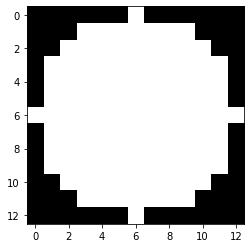

In [29]:
from skimage import morphology

# Structural element, that we will use as a "brush". The parameter is "brush side"
struct_el = morphology.disk(6)

print(struct_el)
plt.imshow(struct_el, cmap='gray')

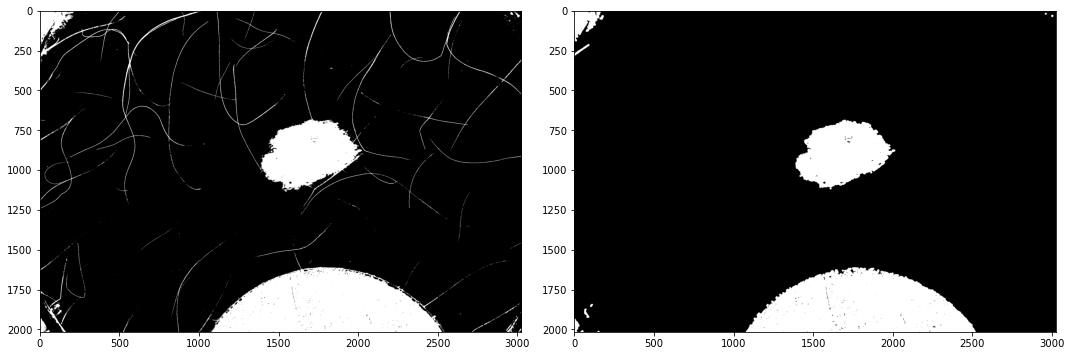

In [30]:
mask2 = morphology.binary_opening(mask, struct_el)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
axes[0].imshow(mask, cmap='gray')
axes[1].imshow(mask2, cmap='gray')
fig.tight_layout()

## Segmentation via pixel classification

In [23]:
def prepare_im(im_id):

  im = plt.imread('example_image/' + im_id + '.jpg')
  im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)
 
  gt = plt.imread('example_segmentation/' + im_id + '_segmentation.png')
  gt = resize(gt, (gt.shape[0] // 4, gt.shape[1] // 4), anti_aliasing=True)


  return im, gt

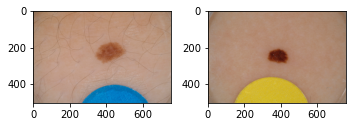

In [24]:
im1, gt1 = prepare_im('ISIC_0001769')
im2, gt2 = prepare_im('ISIC_0001852')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(im1)
axes[1].imshow(im2)
fig.tight_layout()

93.59345184445517 133.37757430410238 157.32972026842836


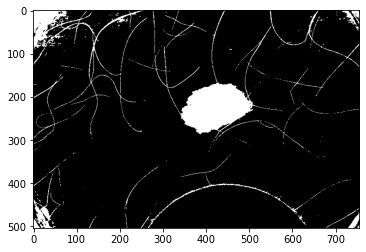

In [24]:
val0 = filters.threshold_otsu(im1[:,:,0]*256)
val1 = filters.threshold_otsu(im1[:,:,1]*256)
val2 = filters.threshold_otsu(im1[:,:,2]*256)
print(val0,val1,val2)

im1mask = (im1[:,:,2]*256<val2) & (im1[:,:,1]*256<val1) 
plt.imshow(im1mask, cmap='gray')

In [20]:
struct_el = morphology.disk(6)

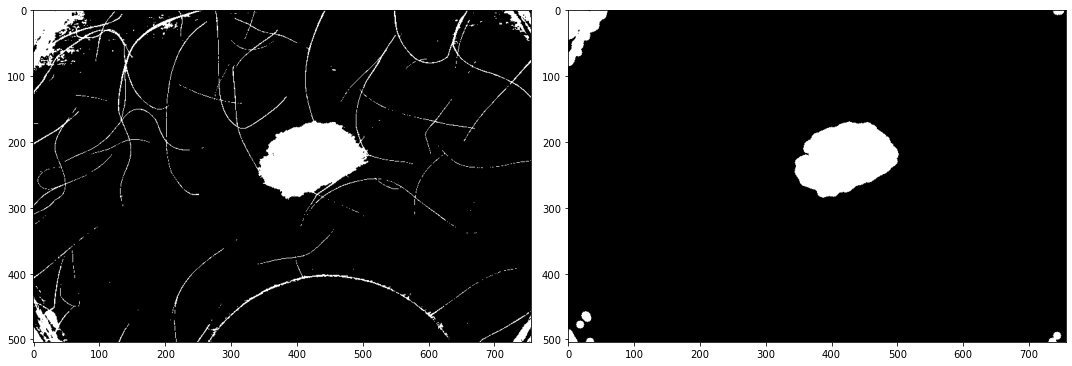

In [21]:
im1mask2 = morphology.binary_opening(im1mask, struct_el)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
axes[0].imshow(im1mask, cmap='gray')
axes[1].imshow(im1mask2, cmap='gray')
fig.tight_layout()

## Segmentation via pixel classification - multiple classifiers

In [233]:
def extract_features(im):

    #Here we select some channels...
    red_feat = im[:,:,0].flatten()
    green_feat = im[:,:,1].flatten()
    blue_feat = im[:,:,2].flatten()

    #Get intensity and blurred intensity
    gray_im = rgb2gray(im)
    gray_feat = gray_im.flatten()
    
    gaussian_im = gaussian(gray_im, 10)
    gaussian_feat = gaussian_im.flatten()

    #Add a coordinate feature
    xcoord = (np.arange(0,im.shape[0]))
    xcoord_im = np.tile(xcoord, [im.shape[1],1]).T
    xcoord_feat = xcoord_im.flatten() // im.shape[0]

    ycoord = (np.arange(0,im.shape[1]))
    ycoord_im = np.tile(ycoord, [im.shape[0],1])
    ycoord_feat = ycoord_im.flatten() // im.shape[1]

    # Here you could extract others, like grayscale intensity, neighboring intensity etc..

    #Put into the same array
    features = np.asarray([green_feat, blue_feat, gaussian_feat, xcoord_feat, ycoord_feat])
    features = features.T 
    return np.asarray(features)

In [25]:
gt1 = gt1>0 #original values are floats, sklearn wants 0s and 1s

x_train = extract_features(im1)
y_train = gt1.flatten()


print(im1.shape)
print(x_train.shape)
print(y_train.shape)

(504, 756, 3)
(381024, 4)
(381024,)


In [26]:
# In principle we would want to scale the features first (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
# More on this next week 

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier()

In [27]:
print(im2.shape)

x_test = extract_features(im2)
print(x_test.shape)

#Apply classifier
y_predict = classifier.predict(x_test)

(504, 756, 3)
(381024, 4)


(381024,)


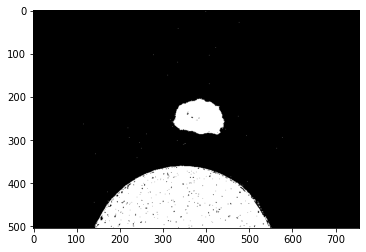

In [28]:
print(y_predict.shape)

mask_predict = y_predict.reshape([im2.shape[0], im2.shape[1]])
plt.imshow(mask_predict, cmap='gray')

### With my example images

In [158]:
def prepare_im(im_id):

  im = plt.imread('example_imgs_ida/' + im_id + '.png')
  im = resize(im, (im.shape[0] // 4, im.shape[1] // 4), anti_aliasing=True)
 
  gt = plt.imread('example_segmentation_ida/' + im_id + '_GT.png')
  gt = resize(gt, (gt.shape[0] // 4, gt.shape[1] // 4), anti_aliasing=True)


  return im, gt

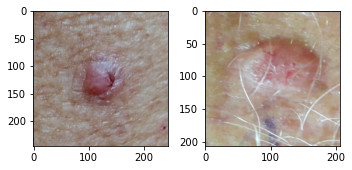

In [159]:
im1, gt1 = prepare_im('PAT_55_84_506')
im2, gt2 = prepare_im('PAT_98_152_562')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(im1)
axes[1].imshow(im2)
fig.tight_layout()

In [160]:
im1 = im1[:,:,0:3]
im2 = im2[:,:,0:3]

In [234]:
gt1 = gt1>0 #original values are floats, sklearn wants 0s and 1s

x_train = extract_features(im1)
y_train = gt1.flatten()


print(im1.shape)
print(x_train.shape)
print(y_train.shape)

(245, 245, 3)
(60025, 5)
(60025,)


In [235]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier()

In [236]:
print(im2.shape)

x_test = extract_features(im2)
print(x_test.shape)

#Apply classifier
y_predict = classifier.predict(x_test)

(207, 207, 3)
(42849, 5)


(42849,)


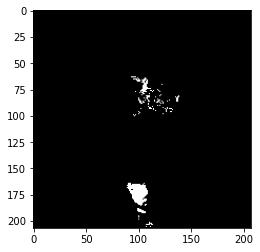

In [237]:
print(y_predict.shape)

mask_predict = y_predict.reshape([im2.shape[0], im2.shape[1]])
plt.imshow(mask_predict, cmap='gray')

149.35614 125.81885 125.07418 126.14882


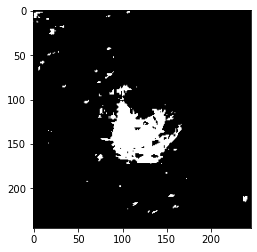

In [241]:
val0 = filters.threshold_otsu(im1[:,:,0]*256)
val1 = filters.threshold_otsu(im1[:,:,1]*256)
val2 = filters.threshold_otsu(im1[:,:,2]*256)

print(val0,val1,val2, valg)

mymask = (im1[:,:,0]*256<val0) & (im1[:,:,1]*256<100) & (im1[:,:,2]*256<125)
plt.imshow(mymask, cmap='gray')

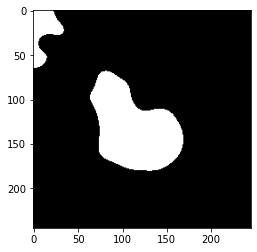

In [246]:
valg = filters.threshold_otsu(gaussian(rgb2gray(im1), 10)*256)
mymask2 = gaussian(rgb2gray(im1), 10)*256 < valg
plt.imshow(mymask2, cmap='gray')

Text(0, 0.5, 'blurred intensity')

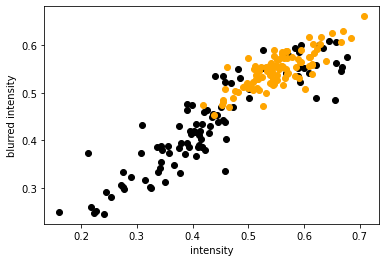

In [42]:
gray_im = rgb2gray(im1)
blurred_im = gaussian(gray_im,5)

lesion = np.array([gray_im[gt1 == 1], blurred_im[gt1 == 1]]).T
skin = np.array([gray_im[gt1 == 0], blurred_im[gt1 == 0]]).T


num_pixels = 100

lesion1 = lesion[np.random.randint(0,lesion.shape[0],num_pixels), :]
skin1 = skin[np.random.randint(0,skin.shape[0],num_pixels), :]

plt.scatter(lesion1[:,0],lesion1[:,1], color='black') 
plt.scatter(skin1[:,0],skin1[:,1], color='orange') 
plt.xlabel('intensity')
plt.ylabel('blurred intensity')

In [202]:
lesion = im2[gt2 == 1]
skin = im2[gt2 == 0]

print(lesion.shape)
print(skin.shape)

num_pixels = 100

lesion = lesion[np.random.randint(0,lesion.shape[0],num_pixels)]
skin = skin[np.random.randint(0,skin.shape[0],num_pixels)]

lesion = lesion*256
skin = skin*256

(6293, 3)
(35292, 3)


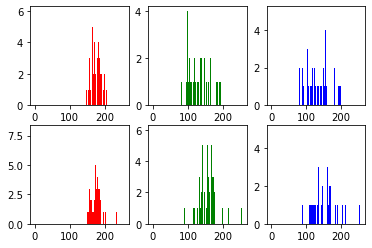

In [203]:
# Look at different channel histograms

fig, ax = plt.subplots(2,3)
bins = np.arange(-0.5, 255+1,1)
ax[0,0].hist(lesion[:,0], bins=bins, color='r')
ax[0,1].hist(lesion[:,1], bins=bins, color='g')
ax[0,2].hist(lesion[:,2], bins=bins, color='b')

ax[1,0].hist(skin[:,0], bins=bins, color='r')
ax[1,1].hist(skin[:,1], bins=bins, color='g')
ax[1,2].hist(skin[:,2], bins=bins, color='b')

plt.show()

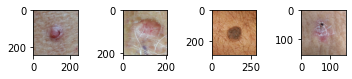

In [97]:
im1, gt1 = prepare_im('PAT_55_84_506')
im2, gt2 = prepare_im('PAT_98_152_562')
im3, gt3 = prepare_im('PAT_1276_957_406')
im4, gt4 = prepare_im('PAT_1688_3066_491')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(5, 3))
axes[0].imshow(im1)
axes[1].imshow(im2)
axes[2].imshow(im3)
axes[3].imshow(im4)
fig.tight_layout()

In [101]:
im1 = im1[:,:,0:3]
im2 = im2[:,:,0:3]
im3 = im3[:,:,0:3]
im4 = im4[:,:,0:3]

In [124]:
gt3 = gt3>0 #original values are floats, sklearn wants 0s and 1s
gt4 = gt4>0

x1_train = extract_features(im3)
x2_train = extract_features(im4)
y1_train = gt3.flatten()
y2_train = gt4.flatten()

print(im1.shape)
print(x_train.shape)
print(y_train.shape)

(245, 245, 3)
(60025, 4)
(60025,)


In [122]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(np.array([x1_train, x2_train]), np.array([y1_train, y2_train]))

C:\Users\idawe\AppData\Local\Temp\ipykernel_11832\555306111.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  classifier.fit(np.array([x1_train, x2_train]), np.array([y1_train, y2_train]))


ValueError: setting an array element with a sequence.

In [117]:
np.array([x1_train, x2_train])

C:\Users\idawe\AppData\Local\Temp\ipykernel_11832\2234077589.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([x1_train, x2_train])


array([array([[0.46598375, 0.69801903, 0.        , 0.        ],
              [0.4422234 , 0.67351925, 0.        , 0.        ],
              [0.50291896, 0.72557825, 0.        , 0.        ],
              ...,
              [0.48746294, 0.70785445, 0.        , 0.        ],
              [0.46142331, 0.69304889, 0.        , 0.        ],
              [0.45266783, 0.6897999 , 0.        , 0.        ]]),
       array([[0.50465542, 0.59712523, 0.        , 0.        ],
              [0.51618582, 0.60832709, 0.        , 0.        ],
              [0.5257706 , 0.61786145, 0.        , 0.        ],
              ...,
              [0.50698042, 0.65562731, 0.        , 0.        ],
              [0.52287239, 0.66914195, 0.        , 0.        ],
              [0.53732532, 0.67597163, 0.        , 0.        ]])],
      dtype=object)

Text(0.5, 0, 'intensity')

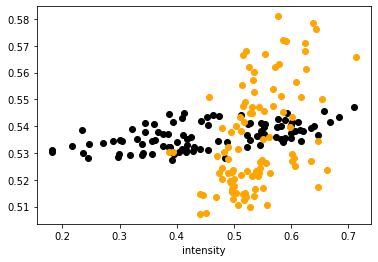

In [220]:
gray_im = rgb2gray(im1)
blurred_im = gaussian(gray_im,100)

lesion = np.array([gray_im[gt1 == 1], blurred_im[gt1 == 1]]).T
skin = np.array([gray_im[gt1 == 0], blurred_im[gt1 == 0]]).T


num_pixels = 100

lesion1 = lesion[np.random.randint(0,lesion.shape[0],num_pixels), :]
skin1 = skin[np.random.randint(0,skin.shape[0],num_pixels), :]

plt.scatter(lesion1[:,0],lesion1[:,1], color='black') 
plt.scatter(skin1[:,0],skin1[:,1], color='orange') 
plt.xlabel('intensity')

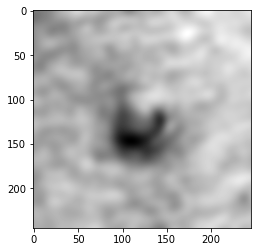

In [238]:
plt.imshow(gaussian(rgb2gray(im1), 5), cmap='gray')

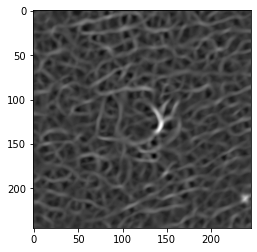

In [266]:
from skimage import feature #for feature extraction
feat_im = feature.multiscale_basic_features(im1, channel_axis=2, intensity=False, edges=True, texture=True, sigma_min = 3, sigma_max = 3)

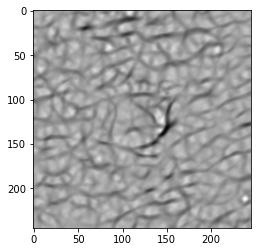

In [275]:
plt.imshow(feat_im[:,:,8], cmap='gray')